# Data cleaning

En este script trabajamos con las variables preseleccionadas según interés del investigador. En los archivos "Base Aprender Directivos/Docentes/Estudiantes de 6to grado de primaria (ver carpeta inputs) pueden encontrarse los cuestionarios completos.

Exploramos missing values

Exploramos variables repetidas por cuestionarios 

Armamos las bases por escuela que luego será utilizada en los modelos. Se construye la variable dependiente, definida como porcentaje de alumnos por escuela resultado satisfactorio y avanzado en ambas materias

# 1. Librerías

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import re
from functools import reduce

#Sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')


# 2. Variables

Importamos los archivos diccionario de variables de los cuestionarios de estudiantes, doncentes y directores. Los files son

#valores_variables_estudiantes_raw

#valores_variables_directores_raw

#valores_variables_docentes_raw

Son los archivos que en las bases originales aparecen con estos nombres

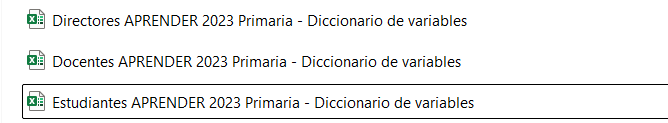

## 2. 1 Estudiantes

In [2]:
#########Valores#########
df_valores_variable_estudiantes = pd.read_excel('../inputs/valores_variables_estudiantes_raw.xlsx', sheet_name='valores',  usecols=[0, 1, 2])
#Esto es para solucionar la primera columna, que tiene celdas combinadas
df_valores_variable_estudiantes.iloc[:, 0] = df_valores_variable_estudiantes.iloc[:, 0].ffill()
#Renombramos las columnas
df_valores_variable_estudiantes.rename(columns={'Variable':'variable', 'Valores':'respuesta', 'Etiqueta':'desc_respuesta'}, inplace=True)

#########Etiquetas#########
df_valores_etiquetas_estudiantes = pd.read_excel('../inputs/valores_variables_estudiantes_raw.xlsx', sheet_name='etiqueta')
df_valores_etiquetas_estudiantes.rename(columns={'Variable':'variable', 'Etiqueta':'desc_variable'}, inplace=True)

#########Consolidamos df de variables de estudiantes#########
df_variables_estudiantes=df_valores_variable_estudiantes.merge(df_valores_etiquetas_estudiantes, on='variable', how='left')
#Reorder columns
df_variables_estudiantes=df_variables_estudiantes[['variable','desc_variable','respuesta', 'desc_respuesta']]
df_variables_estudiantes.head()

,variable,desc_variable,respuesta,desc_respuesta
0,jurisdiccion,Código de Jurisdicción,2,Ciudad Autónoma de Buenos Aires
1,jurisdiccion,Código de Jurisdicción,6,Buenos Aires
2,jurisdiccion,Código de Jurisdicción,10,Catamarca
3,jurisdiccion,Código de Jurisdicción,14,Córdoba
4,jurisdiccion,Código de Jurisdicción,18,Corrientes


#### Variables duplicadas

Queremos detectar las variables que aparecen con más de un código pero poseen la misma descripción. Ejemplo: máximo nivel educativo de los padres aparece más de una vez veces. Exportamos esta tabla. Antes eliminamos dobles espaciados de las descripción, dado que hay variables que aparecen con la misma descripción (duplicadas) pero con espaciado diferentes

In [3]:
########## Eliminamos doble espaciado ########## 
df_variables_estudiantes['desc_variable'] = (
    df_variables_estudiantes['desc_variable']
    .str.strip()                                  # elimina espacios al inicio y final
    .apply(lambda x: re.sub(r'\s+', ' ', x))      # reemplaza múltiples espacios por uno solo
)

########## Buscamos variables duplicadas ########## 
variables_duplicadas_estudiantes =(df_variables_estudiantes[['variable', 'desc_variable']]
    .drop_duplicates()
    .groupby('desc_variable')['variable']
    .unique()
    .reset_index()
)

variables_duplicadas_estudiantes = variables_duplicadas_estudiantes[
    variables_duplicadas_estudiantes['variable'].apply(len) > 1
]

variables_duplicadas_estudiantes.head()

,desc_variable,variable
83,¿Con quién o quiénes vivís? [Mamá],"[ap16a, ap16c]"
85,¿Con quién o quiénes vivís? [Papá],"[ap16b, ap16d]"
88,"¿Cuál es el MÁXIMO nivel educativo de tu mamá,...","[ap20a1, ap20c1]"
89,"¿Cuál es el MÁXIMO nivel educativo de tu mamá,...","[ap20a2, ap20c2]"
111,"¿Dónde nacieron tu/s mamá/s, papá/s opersona/s...","[ap17a, ap17c]"


In [4]:
df_variables_estudiantes_saved=df_variables_estudiantes.copy()

## 2.2 Docentes

In [5]:
#########Valores#########
df_valores_variable_docentes = pd.read_excel('../inputs/valores_variables_docentes_raw.xlsx', sheet_name='valores',  usecols=[0, 1, 2])
#Esto es para solucionar la primera columna, que tiene celdas combinadas
df_valores_variable_docentes.iloc[:, 0] = df_valores_variable_docentes.iloc[:, 0].ffill()
#Renombramos las columnas
df_valores_variable_docentes.rename(columns={'Variable':'variable', 'Valores':'respuesta', 'Etiqueta':'desc_respuesta'}, inplace=True)

#########Etiquetas#########
df_valores_etiquetas_docentes = pd.read_excel('../inputs/valores_variables_docentes_raw.xlsx', sheet_name='etiquetas')
df_valores_etiquetas_docentes.rename(columns={'Variable':'variable', 'Etiqueta':'desc_variable'}, inplace=True)

#########Consolidamos df de variables de docentes#########
df_variables_docentes=df_valores_variable_docentes.merge(df_valores_etiquetas_docentes, on='variable', how='left')
#Reorder columns
df_variables_docentes=df_variables_docentes[['variable','desc_variable','respuesta', 'desc_respuesta']]
df_variables_docentes.head()

,variable,desc_variable,respuesta,desc_respuesta
0,jurisdiccion,Código de Jurisdicción,2,Ciudad Autónoma de Buenos Aires
1,jurisdiccion,Código de Jurisdicción,6,Buenos Aires
2,jurisdiccion,Código de Jurisdicción,10,Catamarca
3,jurisdiccion,Código de Jurisdicción,14,Córdoba
4,jurisdiccion,Código de Jurisdicción,18,Corrientes


#### Variables duplicadas

Chequeamos que no haya variables duplicadas en este cuestionario (no hay)

In [6]:
def limpiar_texto(texto):
    texto = texto.strip()  # eliminar espacios al principio y al final
    texto = re.sub(r'\s+', ' ', texto)  # reemplazar múltiples espacios por uno
    texto = re.sub(r'\[\s+', '[', texto)  # eliminar espacio después de corchete de apertura
    texto = re.sub(r'\s+\]', ']', texto)  # eliminar espacio antes del corchete de cierre
    texto = re.sub(r'\s+([.,:;!?])', r'\1', texto)  # eliminar espacio antes de signos de puntuación
    return texto

df_variables_docentes['desc_variable'] = df_variables_docentes['desc_variable'].apply(limpiar_texto)

variables_duplicadas_docentes = (
    df_variables_docentes[['variable', 'desc_variable']]
    .drop_duplicates()
    .groupby('desc_variable')['variable']
    .unique()
    .reset_index()
)
variables_duplicadas_docentes = variables_duplicadas_docentes[
    variables_duplicadas_docentes['variable'].apply(len) > 1
]

variables_duplicadas_docentes #NO HAY

,desc_variable,variable


In [7]:
df_variables_docentes_saved=df_variables_docentes.copy()

## 2.3 Directores

In [8]:
#########Valores#########
df_valores_variable_directores = pd.read_excel('../inputs/valores_variables_directores_raw.xlsx', sheet_name='valores',  usecols=[0, 1, 2])
#Esto es para solucionar la primera columna, que tiene celdas combinadas
df_valores_variable_directores.iloc[:, 0] = df_valores_variable_directores.iloc[:, 0].ffill()
#Renombramos las columnas
df_valores_variable_directores.rename(columns={'Variable':'variable', 'Valores':'respuesta', 'Etiqueta':'desc_respuesta'}, inplace=True)

#########Etiquetas#########
df_valores_etiquetas_directores = pd.read_excel('../inputs/valores_variables_directores_raw.xlsx', sheet_name='etiquetas')
df_valores_etiquetas_directores.rename(columns={'Variable':'variable', 'Etiqueta':'desc_variable'}, inplace=True)

#########Consolidamos df de variables de directores#########
df_variables_directores=df_valores_variable_directores.merge(df_valores_etiquetas_directores, on='variable', how='left')
#Reorder columns
df_variables_directores=df_variables_directores[['variable','desc_variable','respuesta', 'desc_respuesta']]
df_variables_directores.head()

,variable,desc_variable,respuesta,desc_respuesta
0,jurisdiccion,Código de Jurisdicción,2,Ciudad Autónoma de Buenos Aires
1,jurisdiccion,Código de Jurisdicción,6,Buenos Aires
2,jurisdiccion,Código de Jurisdicción,10,Catamarca
3,jurisdiccion,Código de Jurisdicción,14,Córdoba
4,jurisdiccion,Código de Jurisdicción,18,Corrientes


#### Variables duplicadas

Chequeamos que no haya variables duplicadas en este cuestionario (no hay)

In [9]:
df_variables_directores['desc_variable'] = df_variables_directores['desc_variable'].apply(limpiar_texto)

variables_duplicadas_directores = (
    df_variables_directores[['variable', 'desc_variable']]
    .drop_duplicates()
    .groupby('desc_variable')['variable']
    .unique()
    .reset_index()
)
variables_duplicadas_directores = variables_duplicadas_directores[
    variables_duplicadas_directores['variable'].apply(len) > 1
]

variables_duplicadas_directores

,desc_variable,variable


In [10]:
df_variables_directores_saved=df_variables_directores.copy()

# 3. Bases de datos

Importamos las bases de datos de estudiantes, docentes y directores y calculamos los missings por cada pregunta

Calculamos los valores faltantes sobre el conjunto de variables de interés. Estas fueron seleccionadas a consieración del investigador y se encuentran en el archivo "cuadro_variables", aplicando el filtro "Contempladas"

Del total de 668 variables de estudiantes/docentes/directores, se contamplan alrededor de 190 preguntas a las que luego se le contabilizan los missing y se descartan las preguntas con más de 30% de missings por colegio. También se elimnan las variables duplicadas y aquellas que, luego de validar con fuentes externas (Censo 2022), se descartan por ser ruidosas. 

## 3.1 Estudiantes

In [11]:
df_estudiantes=pd.read_csv('../inputs/Base Aprender Estudiantes 6 Grado Primaria 2023.csv',delimiter=';')

¿Cuántos estudiantes y colegios tienen la base? ¿Rurales y urbanos?

In [12]:
print('Total de colegios:', df_estudiantes['ID1'].nunique())
print('Total de alumnos:', df_estudiantes['idalumno'].nunique())
print('')
print('Colegios por ámbito:',df_estudiantes.groupby('ambito')['ID1'].nunique())
print('')
print('Estudiantes por ámbito:',df_estudiantes.groupby('ambito')['idalumno'].nunique())

Total de colegios: 19834
Total de alumnos: 641981

Colegios por ámbito: ambito
1     7827
2    12007
Name: ID1, dtype: int64

Estudiantes por ámbito: ambito
1     64631
2    577368
Name: idalumno, dtype: int64


Si bien los ponderadores no se usan, los convertimos a número

In [13]:
df_estudiantes['ponder'] = df_estudiantes['ponder'].astype(str).str.replace(',', '.', regex=False)
df_estudiantes['ponder'] = pd.to_numeric(df_estudiantes['ponder'], errors='coerce')

df_estudiantes['mpondera'] = df_estudiantes['mpondera'].astype(str).str.replace(',', '.', regex=False)
df_estudiantes['mpondera'] = pd.to_numeric(df_estudiantes['mpondera'], errors='coerce')

df_estudiantes['lpondera'] = df_estudiantes['lpondera'].astype(str).str.replace(',', '.', regex=False)
df_estudiantes['lpondera'] = pd.to_numeric(df_estudiantes['lpondera'], errors='coerce')


### 3.1.1 Missings por variable

Cargamos el archivo "cuadro_variables.xlsx" mencionado anteriormente y nos quedamos únicamente con las variables "Contempladas"

Los missing no aparecen como NaNs, sino como -9 Blanco, -8 no disponible y -6 multimarca. Vamos a reemplazar todos estos valores, más los " " por NaNs

In [14]:
df_variables_relevantes_estudiantes=pd.read_excel('../inputs/cuadro_variables.xlsx', sheet_name='estudiantes')
df_variables_relevantes_estudiantes=df_variables_relevantes_estudiantes.loc[(df_variables_relevantes_estudiantes['Base']=='Estudiantes')]
lista_variables_relevantes=df_variables_relevantes_estudiantes.loc[df_variables_relevantes_estudiantes['Descartada/contemplada']=='Contemplada']['codigo'].unique()

In [15]:
print(len(lista_variables_relevantes))

134


In [16]:
#########Valores a convertir en nans#########
to_nans = [-6, -8, -9, ' ', "-6", "-9", "-8"]
df_estudiantes = df_estudiantes.replace(to_nans, np.nan)

In [17]:
#########Contamos la cantidad de nans por columna y calculamos el porcentaje#########
nan_counts = df_estudiantes.isna().sum().reset_index()
nan_counts.columns = ['columna', 'cantidad_nulos']

nan_counts['porcentaje_nulos']=(nan_counts['cantidad_nulos']/df_estudiantes.shape[0]*100).round(2)

In [18]:
#########Contamos los nans de nuestras variables relevantes#########
nan_counts=nan_counts.merge(df_variables_relevantes_estudiantes[['codigo','Descartada/contemplada']], left_on='columna', right_on='codigo', how='left')
nan_counts=nan_counts.loc[nan_counts['Descartada/contemplada']=='Contemplada']

Como tenemos variables repetidas, vamos a quedarnos con la variable con menor porcentaje de missings

In [19]:
nulos_dict = nan_counts.set_index('columna')['porcentaje_nulos'].to_dict()

##########Función para elegir mejor y peor variable##########
def obtener_mejor_peor(lista_vars):
    mejor = min(lista_vars, key=lambda x: nulos_dict.get(x, 100))
    peor = max(lista_vars, key=lambda x: nulos_dict.get(x, -1))
    return pd.Series({'mejor_variable': mejor, 'peor_variable': peor})

# Aplicamos la función
variables_duplicadas_estudiantes[['mejor_variable', 'peor_variable']] = variables_duplicadas_estudiantes['variable'].apply(obtener_mejor_peor)
variables_duplicadas_estudiantes

,desc_variable,variable,mejor_variable,peor_variable
83,¿Con quién o quiénes vivís? [Mamá],"[ap16a, ap16c]",ap16a,ap16a
85,¿Con quién o quiénes vivís? [Papá],"[ap16b, ap16d]",ap16b,ap16b
88,"¿Cuál es el MÁXIMO nivel educativo de tu mamá,...","[ap20a1, ap20c1]",ap20a1,ap20c1
89,"¿Cuál es el MÁXIMO nivel educativo de tu mamá,...","[ap20a2, ap20c2]",ap20a2,ap20c2
111,"¿Dónde nacieron tu/s mamá/s, papá/s opersona/s...","[ap17a, ap17c]",ap17a,ap17c
112,"¿Dónde nacieron tu/s mamá/s, papá/s opersona/s...","[ap17b, ap17d]",ap17b,ap17d
121,¿Fué completado ese nivel educativo? Mamá o ad...,"[ap20b1, ap20d1]",ap20b1,ap20d1
122,¿Fué completado ese nivel educativo? Papá o ad...,"[ap20b2, ap20d2]",ap20b2,ap20d2
174,"¿Tu/s mamá/s, papá/s o persona/s adulta/s resp...","[ap19a, ap19c]",ap19a,ap19c
175,"¿Tu/s mamá/s, papá/s o persona/s adulta/s resp...","[ap19b, ap19d]",ap19b,ap19d


A la tabla de variables le agregamos una columna donde, si la variable se repite, descartamos si tiene más Nans

In [20]:
nan_counts=nan_counts.merge(variables_duplicadas_estudiantes[['peor_variable']], left_on='columna', right_on='peor_variable', how='left')
cols_a_reemplazar = ['peor_variable']
nan_counts[cols_a_reemplazar] = nan_counts[cols_a_reemplazar].fillna("")
nan_counts.rename(columns={'columna':'variable'}, inplace=True)

In [21]:
df_variables_estudiantes=df_variables_estudiantes[['variable','desc_variable']].drop_duplicates()

In [22]:
nan_counts=nan_counts.merge(df_variables_estudiantes[['variable','desc_variable']], on='variable', how='left')
nan_counts=nan_counts[['variable','desc_variable', 'cantidad_nulos', 'porcentaje_nulos', 
        'peor_variable','Descartada/contemplada']]

In [23]:
limpieza_base_estudiantes=nan_counts.copy()

Guardamos el archivo (file necesario en otra instancia)

In [24]:
with pd.ExcelWriter('../outputs/limpieza_base_estudiantes.xlsx', engine='openpyxl') as writer:
    nan_counts.to_excel(writer, sheet_name='missing_vars', index=False)
    variables_duplicadas_estudiantes.to_excel(writer, sheet_name='duplicated_vars', index=False)

limpieza_base_estudiantes.to_excel('../outputs/limpieza_base_estudiantes.xlsx')
! gsutil cp "../outputs/limpieza_base_estudiantes.xlsx" gs://resiliency_builder/lucia_pezzarini/    

Copying file://../outputs/limpieza_base_estudiantes.xlsx [Content-Type=application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]...
/ [1 files][ 13.1 KiB/ 13.1 KiB]                                                
Operation completed over 1 objects/13.1 KiB.                                     


## 3.2 Docentes

In [25]:
df_docentes=pd.read_csv('../inputs/Base Aprender Docentes 6 Grado Primaria 2023.csv',delimiter=';')

In [26]:
df_docentes['ponder'] = df_docentes['ponder'].astype(str).str.replace(',', '.', regex=False)
df_docentes['ponder'] = pd.to_numeric(df_docentes['ponder'], errors='coerce')
df_docentes['Edad'] = pd.to_numeric(df_docentes['Edad'], errors='coerce')

### 3.2.1 Missings por variable

In [27]:
df_variables_relevantes_docentes=pd.read_excel('../inputs/cuadro_variables.xlsx', sheet_name='docentes')
df_variables_relevantes_docentes=df_variables_relevantes_docentes.loc[(df_variables_relevantes_docentes['Base']=='Docentes')]

lista_variables_relevantes_docentes=df_variables_relevantes_docentes.loc[df_variables_relevantes_docentes['Descartada/contemplada']=='Contemplada']['codigo'].unique()

In [28]:
df_docentes['region'].unique()

array(['CUYO', 'NEA', 'CENTRO', 'NOA', 'SUR'], dtype=object)

In [29]:
#########Valores a convertir en nans#########
to_nans = [-6, -8, -9, ' ', "-6", "-9", "-8"]
df_docentes = df_docentes.replace(to_nans, np.nan)

In [30]:
#########Contamos la cantidad de nans por columna y calculamos el porcentaje#########
nan_counts = df_docentes.isna().sum().reset_index()
nan_counts.columns = ['columna', 'cantidad_nulos']
nan_counts['porcentaje_nulos']=(nan_counts['cantidad_nulos']/df_docentes.shape[0]*100).round(2)

In [31]:
#########Contamos los nans de nuestras variables relevantes#########
nan_counts=nan_counts.merge(df_variables_relevantes_docentes[['codigo','Descartada/contemplada']], left_on='columna', right_on='codigo', how='left')
nan_counts=nan_counts.loc[nan_counts['Descartada/contemplada']=='Contemplada']

In [32]:
desc_variables=df_variables_docentes[['variable','desc_variable']].drop_duplicates()

In [33]:
nan_counts=nan_counts.merge(desc_variables, left_on='columna', right_on='variable', how='left')

In [34]:
nan_counts.shape

(35, 7)

In [35]:
nan_counts=nan_counts[['variable', 'desc_variable', 'cantidad_nulos', 'porcentaje_nulos','Descartada/contemplada']]

In [36]:
with pd.ExcelWriter('../outputs/limpieza_base_docentes.xlsx', engine='openpyxl') as writer:
    nan_counts.to_excel(writer, sheet_name='missing_vars', index=False)
    

## 3.3 Directores

In [37]:
df_directores=pd.read_csv('../inputs/Base Aprender Directivos 6 Grado Primaria 2023.csv',delimiter=';')

In [38]:
df_directores['ponder'] = df_directores['ponder'].astype(str).str.replace(',', '.', regex=False)
df_directores['ponder'] = pd.to_numeric(df_directores['ponder'], errors='coerce')
df_directores['Edad'] = pd.to_numeric(df_directores['Edad'], errors='coerce')

### 3.2.1 Missings por variable

In [39]:
df_variables_relevantes_directores=pd.read_excel('../inputs/cuadro_variables.xlsx', sheet_name='directores')
df_variables_relevantes_directores=df_variables_relevantes_directores.loc[(df_variables_relevantes_directores['Base']=='Directores')]

lista_variables_relevantes_directores=df_variables_relevantes_directores.loc[df_variables_relevantes_directores['Descartada/contemplada']=='Contemplada']['codigo'].unique()

In [40]:
#########Valores a convertir en nans#########
to_nans = [-6, -8, -9, ' ', "-6", "-9", "-8"]
df_directores = df_directores.replace(to_nans, np.nan)

In [41]:
#########Contamos la cantidad de nans por columna y calculamos el porcentaje#########
nan_counts = df_directores.isna().sum().reset_index()
nan_counts.columns = ['columna', 'cantidad_nulos']
nan_counts['porcentaje_nulos']=(nan_counts['cantidad_nulos']/df_directores.shape[0]*100).round(2)

In [42]:
#########Contamos los nans de nuestras variables relevantes#########
nan_counts=nan_counts.merge(df_variables_relevantes_directores[['codigo','Descartada/contemplada']], left_on='columna', right_on='codigo', how='left')
nan_counts=nan_counts.loc[nan_counts['Descartada/contemplada']=='Contemplada']

In [43]:
desc_variables=df_variables_directores[['variable','desc_variable']].drop_duplicates()

In [44]:
nan_counts=nan_counts.merge(desc_variables, left_on='columna', right_on='variable', how='left')

In [45]:
nan_counts=nan_counts[['variable', 'desc_variable', 'cantidad_nulos', 'porcentaje_nulos','Descartada/contemplada']]

In [46]:
with pd.ExcelWriter('../outputs/limpieza_base_directores.xlsx', engine='openpyxl') as writer:
    nan_counts.to_excel(writer, sheet_name='missing_vars', index=False)
 

# 4. Bases por colegio

En la sección anterior, contabamos los missings a nivel estudiantes, docentes y directores para descartar ciertas variables. Ahora armamos las bases por colegio a partir de los promedios de las bases de estudiantes, docentes y agregando la base de directores (no hay que promediar nada, dado que es un director por colegio)

## 4.1 Estudiantes

Importamos la lista de variables contampadas de estudiantes y vamos a filtrar los missings y luego promediar por colegio

**En esta sección hacemos tres cosas:**

1. Creamos la variable personas_por_habitacion y luego borramos personas en el hogar y número de habitaciones. 

2. Armamos un df con características del colegio: jurisdicción, ámbito, sector, cantidad de alumnos, cantidad de alumnos que contestaron matemática y cantidad de alumnos que contestaron lengua.

3. Descartamos colegios con muchos missings

4. Armamos promedios por variables. Necesitamos una fila por colegio, ¿cómo colapsamos las variables?


* Para las variables numéricas, promedio simple -->lpuntaje, mpuntaje, NSE_puntaje, personas_por_habitacion, clima_escolar
* Para las categóricas hacemos one hot encoding (dummies) y luego obtenemos resultados como: porcentaje de madres con primaria completa (20%), con secundaria (30%), etc

In [47]:
##########Lista de variables con # de missings##########
df_variables_estudiantes=pd.read_excel('../outputs/limpieza_base_estudiantes.xlsx').iloc[:,1:]
df_variables_estudiantes=df_variables_estudiantes.loc[df_variables_estudiantes['peor_variable'].isna()]
df_variables_estudiantes.shape

(122, 6)

In [48]:
##########Filtramos valores faltantes menores a 30%##########
df_variables_estudiantes=df_variables_estudiantes.loc[df_variables_estudiantes['porcentaje_nulos']<30]
df_variables_estudiantes.shape

(75, 6)

In [49]:
lista_variables_estudiantes = df_variables_estudiantes['variable'].unique().tolist()

Agreamos sección y eliminamos NSE_nivel

In [50]:
lista_variables_estudiantes.append('seccion')
lista_variables_estudiantes.remove('NSE_nivel')

In [51]:
df_estudiantes=pd.read_csv('../inputs/Base Aprender Estudiantes 6 Grado Primaria 2023.csv',delimiter=';')
df_estudiantes.shape

(642006, 206)

In [53]:
######### Variables a las que no le vamos a aplicar el encoding ##########
cols_to_keep=['ID1', 'jurisdiccion', 'seccion','sector', 'ambito','idalumno','lpuntaje','mpuntaje', 'mpondera', 'lpondera']
cols_to_keep=cols_to_keep+lista_variables_estudiantes
print(len(cols_to_keep))

######### Para eliminar valores duplicados de la lista #########
cols_to_keep = list(set(cols_to_keep))
print(len(cols_to_keep))

85
77


In [54]:
#########Filtramos las columnas de la base estudiantes que nos interesan#########
df_estudiantes=df_estudiantes[cols_to_keep]

In [55]:
#########Convertimos a nans##########
to_nans = [-6, -8, -9, ' ', "-6", "-9", "-8"]
df_estudiantes = df_estudiantes.replace(to_nans, np.nan)

La variable sobreedad es 0 cuando tiene menos edad, 1 si tiene la edad correcta para ese grado de colegio, 2, 3 y 4 si tiene 1, 2 o 3 años más. Se codificaron dos variables nuevas:
"menos edad" (dummie) y "sobreedad" (dummie)

In [56]:
########### Crear columna 'menos_edad'###########
df_estudiantes['menos_edad'] = df_estudiantes['sobreedad'].apply(
    lambda x: 1 if x == 0 else (np.nan if pd.isna(x) else 0)
)

########### Crear columna 'sobreedad_dummy'###########
df_estudiantes['sobreedad_dummy'] = df_estudiantes['sobreedad'].apply(
    lambda x: 1 if x in [2, 3, 4] else (np.nan if pd.isna(x) else 0)
)

df_estudiantes.drop(columns=['sobreedad'], inplace=True)

############ Renombrar 'sobreedad_dummy' a 'sobreedad'###########
df_estudiantes.rename(columns={'sobreedad_dummy': 'sobreedad'}, inplace=True)

In [57]:
df_estudiantes['mpondera'] = df_estudiantes['mpondera'].astype(str).str.replace(',', '.', regex=False)
df_estudiantes['mpondera'] = pd.to_numeric(df_estudiantes['mpondera'], errors='coerce')

df_estudiantes['lpondera'] = df_estudiantes['lpondera'].astype(str).str.replace(',', '.', regex=False)
df_estudiantes['lpondera'] = pd.to_numeric(df_estudiantes['lpondera'], errors='coerce')

df_estudiantes['mpuntaje'] = df_estudiantes['mpuntaje'].astype(str).str.replace(',', '.', regex=False)
df_estudiantes['mpuntaje'] = pd.to_numeric(df_estudiantes['mpuntaje'], errors='coerce')

df_estudiantes['lpuntaje'] = df_estudiantes['lpuntaje'].astype(str).str.replace(',', '.', regex=False)
df_estudiantes['lpuntaje'] = pd.to_numeric(df_estudiantes['lpuntaje'], errors='coerce')

df_estudiantes['NSE_puntaje'] = df_estudiantes['NSE_puntaje'].astype(str).str.replace(',', '.', regex=False)
df_estudiantes['NSE_puntaje'] = pd.to_numeric(df_estudiantes['NSE_puntaje'], errors='coerce')


############ Cuántas habitaciones hay donde vivis#########
df_estudiantes['ap14'] = df_estudiantes['ap14'].astype(str).str.replace(',', '.', regex=False)
df_estudiantes['ap14'] = pd.to_numeric(df_estudiantes['ap14'], errors='coerce')
############ Cuántas personas viven en tu casa#########
df_estudiantes['ap15'] = df_estudiantes['ap15'].astype(str).str.replace(',', '.', regex=False)
df_estudiantes['ap15'] = pd.to_numeric(df_estudiantes['ap15'], errors='coerce')

In [58]:
############Creamos variable "personas_por_habitacion"############
df_estudiantes['personas_por_habitacion']=df_estudiantes['ap15'] /df_estudiantes['ap14'] 

In [59]:
############Droppeamos personas en el hogar y número de habitaciones############
df_estudiantes.drop(columns=['ap15','ap14'], inplace=True)

#### Características del colegio

Creamos la columna cantidad de alumnos por colegio. Luego contamos los missings de respuesta en mpuntaje y lpuntaje y tomamos el ratio. Nos sirve para descartar colegios con muchos missings.

In [60]:
############Alumnos por colegio############
df_alumnos_por_colegio=df_estudiantes.groupby('ID1')['idalumno'].nunique().reset_index(name='numero_alumnos')

## LENGUA
############Eliminamos las filas que son NAN en lpuntaje############
df_alumnos_por_colegio_sin_missings_lengua=df_estudiantes.loc[df_estudiantes['lpuntaje'].notna()]

############Contamos, por colegio, el número de alumnos con respuesta NO nan############
df_alumnos_por_colegio_sin_missings_lengua=df_alumnos_por_colegio_sin_missings_lengua.groupby('ID1')['idalumno'].nunique().reset_index(name='not_missing_lengua')

############Imprimimos para ver la cantidad de colegios que queda en c/ df. Hay colegios que tienen solo NaNs##########
print('Total colegios')
print(df_alumnos_por_colegio.shape)
print('Colegios con al menos un alumno que contestó en Lengua')
print(df_alumnos_por_colegio_sin_missings_lengua.shape)
print('Colegios con al menos un alumno que contestó Matemática')

## MATEMÁTICA
############Eliminamos las filas que son NAN en mpuntaje############
df_alumnos_por_colegio_sin_missings_matematica=df_estudiantes.loc[df_estudiantes['mpuntaje'].notna()]

############Contamos, por colegio, el número de alumnos con respuesta NO nan############
df_alumnos_por_colegio_sin_missings_matematica=df_alumnos_por_colegio_sin_missings_matematica.groupby('ID1')['idalumno'].nunique().reset_index(name='not_missing_matematica')
print(df_alumnos_por_colegio_sin_missings_matematica.shape)


## LENGUA y MATEMÁTICA en conjunto, es lo que usamos en la versión final de este trabajo
############Eliminamos las filas que son NAN en lpuntaje o mpuntaje############
df_alumnos_por_colegio_sin_missings_matematica_y_lengua = df_estudiantes.loc[
    df_estudiantes['mpuntaje'].notna() & df_estudiantes['lpuntaje'].notna()
]
############Contamos, por colegio, el número de alumnos con respuesta NO nan############
df_alumnos_por_colegio_sin_missings_matematica_y_lengua=df_alumnos_por_colegio_sin_missings_matematica_y_lengua.groupby('ID1')['idalumno'].nunique().reset_index(name='not_missing_matematica_ni_lengua')

print('Colegios con al menos un alumno que contestó lengua y matemática')
print(df_alumnos_por_colegio_sin_missings_matematica_y_lengua.shape)


Total colegios
(19834, 2)
Colegios con al menos un alumno que contestó en Lengua
(19244, 2)
Colegios con al menos un alumno que contestó Matemática
(19216, 2)
Colegios con al menos un alumno que contestó lengua y matemática
(19186, 2)


In [61]:
############Contamos secciones por colegio############
df_estudiantes['secciones_por_colegio'] = df_estudiantes.groupby('ID1')['seccion'].transform('nunique')

Armamos un df con variables características del colegio: jurisdicción, ámbito, sector

In [63]:
############Datos colegios############
datos_colegio=df_estudiantes[['ID1','secciones_por_colegio','jurisdiccion', 'sector', 'ambito']].drop_duplicates()

############Agregamos descripciones a las variables############
##JURISDICCIÓN
jurisdiccion=df_variables_estudiantes_saved.loc[df_variables_estudiantes_saved['variable']=='jurisdiccion']
datos_colegio=datos_colegio.merge(jurisdiccion[['respuesta', 'desc_respuesta']], left_on='jurisdiccion',  right_on='respuesta', how='left')
##SECTOR
sector=df_variables_estudiantes_saved.loc[df_variables_estudiantes_saved['variable']=='sector']
datos_colegio=datos_colegio.merge(sector[['respuesta', 'desc_respuesta']], left_on='sector',  right_on='respuesta', how='left')
##ÁMBITO
ambito=df_variables_estudiantes_saved.loc[df_variables_estudiantes_saved['variable']=='ambito']
datos_colegio=datos_colegio.merge(ambito[['respuesta', 'desc_respuesta']], left_on='ambito',  right_on='respuesta', how='left')
##REGIÓN
region=pd.read_csv('../inputs/Base Aprender Directivos 6 Grado Primaria 2023.csv',delimiter=';')[['ID1', 'region']]
datos_colegio=datos_colegio.merge(region, left_on='ID1', right_on='ID1', how='left')

########## Renombramos columnas ##########
datos_colegio=datos_colegio[['ID1',
       'desc_respuesta_x', 'desc_respuesta_y',
       'desc_respuesta','secciones_por_colegio', 'region']]
datos_colegio.rename(columns={'desc_respuesta_x':'jurisdiccion', 'desc_respuesta_y':'sector', 'desc_respuesta':'ambito'}, inplace=True)

Hay colegios con NaNs en regiones, pero que tienen datos de provincia. Hacemos el mapeo y completamos.

In [64]:
region_por_jurisdiccion = (
    datos_colegio.loc[datos_colegio['region'].notna(), ['jurisdiccion', 'region']]
    .drop_duplicates('jurisdiccion')
    .set_index('jurisdiccion')['region']
    .to_dict()
)

datos_colegio['region'] = datos_colegio.apply(
    lambda row: region_por_jurisdiccion.get(row['jurisdiccion'], row['region']),
    axis=1
)

datos_colegio.loc[datos_colegio['region'].isna()]

,ID1,jurisdiccion,sector,ambito,secciones_por_colegio,region


Como la regla para descartar o considerar colegios es a partir de la cantidad de alumnos con respuestas en los cuestionarios, mergeamos ambos dataframes: el que contabilizar el # de alumnos por colegio y con respuestas, y el df con características del colegio (jurisdicción, sector,ámbito)

Las variablas pct_not_missing_matemática_ni_lengua refiere al % de alumnos del colegio que contestó ambos exámenes; mienras que not_missing_matemática_ni_lengua, refiere a su valor absoluto. Ej, si esa variable es 12, significa que 12 alumnos del colegio realizaron ambos exámenes

In [65]:
###########Mergeamos ambos df##########
df_alumnos_por_colegio=df_alumnos_por_colegio.merge(datos_colegio, on='ID1', how='left')

###########Agregamos missings##########
df_alumnos_por_colegio=df_alumnos_por_colegio.merge(df_alumnos_por_colegio_sin_missings_matematica, on='ID1', how='left')
df_alumnos_por_colegio=df_alumnos_por_colegio.merge(df_alumnos_por_colegio_sin_missings_lengua, on='ID1', how='left')
df_alumnos_por_colegio=df_alumnos_por_colegio.merge(df_alumnos_por_colegio_sin_missings_matematica_y_lengua, on='ID1', how='left')

###########Reordenamos columnas##########
cols_order=['ID1', 'secciones_por_colegio', 'jurisdiccion', 'sector', 'ambito','numero_alumnos',
       'not_missing_matematica', 'not_missing_lengua', 'not_missing_matematica_ni_lengua']
df_alumnos_por_colegio=df_alumnos_por_colegio[cols_order]
df_alumnos_por_colegio['pct_not_missings_lengua']=(df_alumnos_por_colegio['not_missing_lengua']/df_alumnos_por_colegio['numero_alumnos']).round(2)
df_alumnos_por_colegio['pct_not_missings_matematica']=(df_alumnos_por_colegio['not_missing_matematica']/df_alumnos_por_colegio['numero_alumnos']).round(2)
df_alumnos_por_colegio['pct_not_missings_matematica_ni_lengua']=(df_alumnos_por_colegio['not_missing_matematica_ni_lengua']/df_alumnos_por_colegio['numero_alumnos']).round(2)

df_alumnos_por_colegio.head()

,ID1,secciones_por_colegio,jurisdiccion,sector,ambito,numero_alumnos,not_missing_matematica,not_missing_lengua,not_missing_matematica_ni_lengua,pct_not_missings_lengua,pct_not_missings_matematica,pct_not_missings_matematica_ni_lengua
0,20004002000400,2,Mendoza,Estatal,Urbano,38,36.0,36.0,34.0,0.95,0.95,0.89
1,21604002160400,1,Misiones,Estatal,Urbano,15,12.0,10.0,10.0,0.67,0.80,0.67
2,32804003280400,1,Santa Fe,Estatal,Rural,5,5.0,5.0,5.0,1.00,1.00,1.00
3,32808003280800,1,Santa Fe,Estatal,Rural,12,12.0,12.0,12.0,1.00,1.00,1.00
4,32812003281200,3,Santa Fe,Estatal,Urbano,73,72.0,71.0,71.0,0.97,0.99,0.97


Descartamos colegios con todas respuestas missings y menos de 5 alumnos con respuestas totales

In [67]:
print('Promedio de cobertura en lengua por colegio', df_alumnos_por_colegio['pct_not_missings_lengua'].mean().round(3))
print('Promedio de missings en matemática por colegio', df_alumnos_por_colegio['pct_not_missings_matematica'].mean().round(3))
print('Promedio de missings en matemática y lengua por colegio', df_alumnos_por_colegio['pct_not_missings_matematica_ni_lengua'].mean().round(3))

Promedio de cobertura en lengua por colegio 0.954
Promedio de missings en matemática por colegio 0.944
Promedio de missings en matemática y lengua por colegio 0.932


**LENGUA**

Colegios con lpuntaje todo NAN ¿cómo los eliminamos? : si pct_not_missings_lengua es NA, es porque not_missing_lengua es NA y esto SOLO PASA CUANDO EL COLEGIO SOLO TIENE NANs en lpuntaje

In [68]:
print("Total colegios", len(df_alumnos_por_colegio))

###########Colegios con solo NaNs en lengua #############
colegios_all_missing_lengua=df_alumnos_por_colegio.loc[df_alumnos_por_colegio['pct_not_missings_lengua'].isna()]['ID1'].unique()
colegios_all_missing_lengua = colegios_all_missing_lengua.tolist()
print("Colegios con todos nans en lpuntaje", len(colegios_all_missing_lengua))

###########Colegios al menos 5 alumnos en lpuntaje#############
colegios_desde_5_alumnos_lengua = (
    df_alumnos_por_colegio
    .loc[df_alumnos_por_colegio['pct_not_missings_lengua'].notna() &  # que el porcentaje de missings no sea NA
         (df_alumnos_por_colegio['not_missing_lengua'] > 4), 'ID1'] #que tenga al menos 5 estudiantes
    .unique()
)
colegios_desde_5_alumnos_lengua = colegios_desde_5_alumnos_lengua.tolist()
print("Colegios con al menos 5 alumnos con respuesta", len(colegios_desde_5_alumnos_lengua))

Total colegios 19834
Colegios con todos nans en lpuntaje 590
Colegios con al menos 5 alumnos con respuesta 14650


In [69]:
print("porcentaje_total_colegios_considerados:", len(set(colegios_desde_5_alumnos_lengua))/df_alumnos_por_colegio['ID1'].nunique())

porcentaje_total_colegios_considerados: 0.7386306342643945


**MATEMÁTICA**

In [70]:
print("Total colegios", len(df_alumnos_por_colegio))

###########Colegios con solo NaNs en matemática #############
colegios_all_missing_matematica=df_alumnos_por_colegio.loc[df_alumnos_por_colegio['pct_not_missings_matematica'].isna()]['ID1'].unique()
colegios_all_missing_matematica = colegios_all_missing_matematica.tolist()
print("Colegios con todos nans en mpuntaje",len(colegios_all_missing_matematica))


###########Colegios al menos 5 alumnos en mpuntaje#############
colegios_desde_5_alumnos_matematica = (
    df_alumnos_por_colegio
    .loc[df_alumnos_por_colegio['pct_not_missings_matematica'].notna() &  # que el porcentaje de missings no sea NA
         (df_alumnos_por_colegio['not_missing_matematica'] > 4), 'ID1'] #que tenga al menos 5 estudiantes
    .unique()
)

colegios_desde_5_alumnos_matematica = colegios_desde_5_alumnos_matematica.tolist()
print("Colegios con al menos 5 alumnos con respuesta",len(colegios_desde_5_alumnos_matematica))

Total colegios 19834
Colegios con todos nans en mpuntaje 618
Colegios con al menos 5 alumnos con respuesta 14616


In [71]:
print("porcentaje_total_colegios_considerados:", len(set(colegios_desde_5_alumnos_matematica))/df_alumnos_por_colegio['ID1'].nunique())

porcentaje_total_colegios_considerados: 0.7369164061712211


In [72]:
len(colegios_desde_5_alumnos_matematica)

14616

**Colegios para excluir cuando consideramos ambas materias**

Colegios con mpuntaje o lpuntaje todo NAN: es decir, o tienen todo missing en matematica o lengua.

Arriba vimos que los que tienen TODO missing en lengua son 590 y todo en matemática 618

In [73]:
print("Total colegios", len(df_alumnos_por_colegio))

###########Colegios con solo NaNs en matemática #############
colegios_all_missing_matematica_o_lengua=df_alumnos_por_colegio.loc[df_alumnos_por_colegio['not_missing_matematica_ni_lengua'].isna()]['ID1'].unique()
colegios_all_missing_matematica_o_lengua = colegios_all_missing_matematica_o_lengua.tolist()
print("Colegios con todos nans en lengua o matematica",len(colegios_all_missing_matematica_o_lengua))

###########Colegios al menos 5 alumnos en lpuntaje Y mpuntaje#############
colegios_desde_5_alumnos_lengua_y_matematica= (
    df_alumnos_por_colegio
    .loc[df_alumnos_por_colegio['not_missing_matematica_ni_lengua'].notna() &  # que el porcentaje de missings no sea NA
         (df_alumnos_por_colegio['not_missing_matematica_ni_lengua'] > 4), 'ID1'] #que tenga al menos 5 estudiantes
    .unique()
)


colegios_desde_5_alumnos_lengua_y_matematica = colegios_desde_5_alumnos_lengua_y_matematica.tolist()
print("Colegios con al menos 5 alumnos con respuesta",len(colegios_desde_5_alumnos_lengua_y_matematica))

Total colegios 19834
Colegios con todos nans en lengua o matematica 648
Colegios con al menos 5 alumnos con respuesta 14566


In [74]:
print("porcentaje_total_colegios_considerados:", len(set(colegios_desde_5_alumnos_lengua_y_matematica))/df_alumnos_por_colegio['ID1'].nunique())

porcentaje_total_colegios_considerados: 0.7343954825047898


Además, como vamos a considerar solo colegios urbanos, la muestra final será de 

In [75]:
len(set(
    df_alumnos_por_colegio.loc[
        df_alumnos_por_colegio['not_missing_matematica_ni_lengua'].notna() &
        (df_alumnos_por_colegio['not_missing_matematica_ni_lengua'] > 4) &
        (df_alumnos_por_colegio['ambito'] == 'Urbano'),
        'ID1'
    ]
))

11357

#### Promedios por colegio de las variables de estudiantes

Vamos a promediar a las variables numéricas, crear dummies para las categóricas y luego calcular el porcentaje de alumnos por colegio que cumple con esa condición. Por ejemplo, porcentaje de alumnos del colegio con madres universitarias

No variables: ID1, idalumno

Numéricas: lpuntaje, mpuntaje, NSE_puntaje, clima_escolar, personas_por_habitacion, secciones_por_colegio

Para el resto hay que crear un encoding

In [76]:
########## Convertimos las variables numéricas ##########
to_int = ['mdesemp', 'ldesemp', 'clima_escolar', 'mpuntaje', 'lpuntaje', 'NSE_puntaje', 'personas_por_habitacion', 'secciones_por_colegio']
df_estudiantes[to_int] = df_estudiantes[to_int].apply(
    pd.to_numeric, errors='coerce'
)

########## Definimos los tipos de variables a convertir ##########
y_numeric=['mpuntaje', 'lpuntaje'] 
x_numericas=['clima_escolar','NSE_puntaje', 'personas_por_habitacion', 'secciones_por_colegio']

##Se excluyen porque son características del colegio o son outputs
resto=['ID1','idalumno', 'jurisdiccion','sector','ambito', 'region', 'seccion', 'mdesemp','ldesemp',  'NSE_nivel']

##Se excluyen porque son ponderadores y además no se usan
ponderadores=['mpondera', 'lpondera']

##Lista para  excluir del encoding
to_exclude= y_numeric + x_numericas + resto + ponderadores

##Lista para  incluir del encoding
lista_variables_estudiantes_to_dummie = list(
    set(lista_variables_estudiantes)
    - set(to_exclude) 
)


###Removemos número de habitaciones y número de personas en el hogar y agregamos satisfactorio ambas
lista_variables_estudiantes_to_dummie.remove('ap15')
lista_variables_estudiantes_to_dummie.remove('ap14')
len(lista_variables_estudiantes_to_dummie)

print(len(lista_variables_estudiantes_to_dummie))

########### Convertimos las dummies a objeto ###########
for col in lista_variables_estudiantes_to_dummie:
        df_estudiantes[col] = df_estudiantes[col].astype('object')

60


In [77]:
######### Creamos una variable que sea satisfactorio en ambas (dummie). Esta es la variable output que se utiliza en el trabajo #########
def clasificar(ld, md):
    if pd.isna(ld) or pd.isna(md):
        return np.nan
    elif ld in [3.0, 4.0] and md in [3.0, 4.0]:
        return 1
    else:
        return 0

df_estudiantes['satisfactorio_ambas'] = df_estudiantes.apply(lambda row: clasificar(row['ldesemp'], row['mdesemp']), axis=1)

######### La agregamos como variable a convertir a dummie en el siguiente paso ##########
lista_variables_estudiantes_to_dummie.append('satisfactorio_ambas')

In [78]:
df_estudiantes.groupby('satisfactorio_ambas')['idalumno'].count().reset_index()

,satisfactorio_ambas,idalumno
0,0.0,315725
1,1.0,269627


In [79]:
df_estudiantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642006 entries, 0 to 642005
Data columns (total 79 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ap05e                    514645 non-null  object 
 1   ap12                     559336 non-null  object 
 2   mpondera                 595662 non-null  float64
 3   ap21                     563482 non-null  object 
 4   ap16c                    611832 non-null  object 
 5   lpondera                 603593 non-null  float64
 6   ap09e                    613903 non-null  object 
 7   ap28                     570109 non-null  object 
 8   ap09k                    613903 non-null  object 
 9   ap01                     613903 non-null  object 
 10  ap05g                    479615 non-null  object 
 11  ap20b1                   606815 non-null  object 
 12  Nivel_Ed_Madre           621516 non-null  object 
 13  NSE_puntaje              642006 non-null  float64
 14  ap04

In [80]:
print('Porcentaje de alumnos con satisfactorio o más en ambas materias:',round((269627/(269627+315725)*100),2))

Porcentaje de alumnos con satisfactorio o más en ambas materias: 46.06


Armamos el dataset final con resultados de lengua y matemática en conjunto. La variable output es "satisfactorio_ambas". Si ese valor para el colegio es, por ejemplo 40%, implica que el 40% de los alumnos que dio ambos examenes obtuvo funtajes satisfactorios o más.

Exploramos además que pasa con las variables que son NaNs para algunos colegios.

Por último, eliminamos una categoría de cada pregunta, para que, por fila, las dummies de una categoría no sumen 100%.

##### Matemática y Lengua juntas

**Dummies**

In [81]:
df_estudiantes_matematica_y_lengua=df_estudiantes.copy()

In [82]:
df_estudiantes_matematica_y_lengua.drop(['mpondera','mdesemp','ldesemp', 'mpuntaje', 'lpondera','lpuntaje'],axis=1, inplace=True)

In [83]:
#Chequeamos que solo promedie los alumnos que hayan contestado ambos cuestionarios

In [84]:
df_estudiantes_matematica_y_lengua.columns.to_list()

['ap05e',
 'ap12',
 'ap21',
 'ap16c',
 'ap09e',
 'ap28',
 'ap09k',
 'ap01',
 'ap05g',
 'ap20b1',
 'Nivel_Ed_Madre',
 'NSE_puntaje',
 'ap04',
 'Nivel_Ed_Padre',
 'ap27d',
 'ap27c',
 'ap07b',
 'ap20b2',
 'ap17a',
 'ap06c',
 'clima_escolar',
 'ap05a',
 'migracion',
 'ap08',
 'ap06e',
 'ap10',
 'ap05d',
 'ap20a1',
 'ap18b',
 'region',
 'ID1',
 'ap23',
 'ap27b',
 'ap29',
 'ambito',
 'ap03',
 'ap13',
 'ap07a',
 'edadA_junio2023',
 'sector',
 'ap11',
 'ap05c',
 'ap09c',
 'ap06d',
 'ap09g',
 'ap17b',
 'ap22',
 'ap09b',
 'ap05f',
 'seccion',
 'ap09f',
 'ap19a',
 'ap09d',
 'ap20a2',
 'ap09j',
 'ap09i',
 'ap06a',
 'ap06b',
 'ap16d',
 'idalumno',
 'ap05b',
 'ap05h',
 'ap09a',
 'ap09h',
 'jurisdiccion',
 'ap27a',
 'ap18a',
 'ap26',
 'menos_edad',
 'sobreedad',
 'personas_por_habitacion',
 'secciones_por_colegio',
 'satisfactorio_ambas']

Sacamos estas variables y convertimos el resto a objeto

Primero creamos las **dummies** y luego sacamos el % de cada variable

In [85]:
'''

#Esto era la version anterior cuando promeaidaba todos los estudiantes, indeendietmente de si habia hecho la prueba o no
resultados = []

for var in lista_variables_estudiantes_to_dummie:

    # 1. Obtener dummies para esa variable
    dummies = pd.get_dummies(df_estudiantes_matematica_y_lengua[var], prefix=var)

    # 2. Armar base con ID1 + dummies
    base = pd.concat([df_estudiantes_matematica_y_lengua[['ID1']], dummies], axis=1)

    # 3. Agrupar por colegio y sumar los dummies (cuántos estudiantes hay en cada categoría)
    agrupado = base.groupby('ID1').sum()

    # 4. Calcular el total de estudiantes por colegio
    agrupado['total_estudiantes'] = agrupado.sum(axis=1)

    # 5. Calcular proporciones por categoría
    for col in dummies.columns:
        agrupado[col + '_pct'] = agrupado[col] / agrupado['total_estudiantes']

    # 6. Filtrar solo las columnas de proporciones
    resultado_var = agrupado[[col for col in agrupado.columns if '_pct' in col]].copy()

    # 7. Guardar resultado intermedio
    resultados.append(resultado_var)
    

df_estudiantes_categoricas = pd.concat(resultados, axis=1).reset_index()
df_estudiantes_categoricas[['ID1','satisfactorio_ambas_0.0_pct',
 'satisfactorio_ambas_1.0_pct']].head()
 '''

resultados = []

for var in lista_variables_estudiantes_to_dummie:

    # 0. Filtrar filas donde satisfactorio_ambas no sea nulo
    df_filtrado = df_estudiantes_matematica_y_lengua[df_estudiantes_matematica_y_lengua['satisfactorio_ambas'].notna()].copy()

    # 1. Obtener dummies para esa variable
    dummies = pd.get_dummies(df_filtrado[var], prefix=var)

    # 2. Armar base con ID1 + dummies
    base = pd.concat([df_filtrado[['ID1']], dummies], axis=1)

    # 3. Agrupar por colegio y sumar los dummies
    agrupado = base.groupby('ID1').sum()

    # 4. Calcular el total de estudiantes por colegio (sólo entre los que tienen dato en satisfactorio_ambas)
    agrupado['total_estudiantes'] = agrupado[dummies.columns].sum(axis=1)

    # 5. Calcular proporciones por categoría
    for col in dummies.columns:
        agrupado[col + '_pct'] = agrupado[col] / agrupado['total_estudiantes']

    # 6. Filtrar solo las columnas de proporciones
    resultado_var = agrupado[[col for col in agrupado.columns if '_pct' in col]].copy()

    # 7. Guardar resultado intermedio
    resultados.append(resultado_var)

# Concatenar resultados
df_estudiantes_categoricas = pd.concat(resultados, axis=1).reset_index()

df_estudiantes_categoricas[['ID1','satisfactorio_ambas_0.0_pct',
 'satisfactorio_ambas_1.0_pct']].head()

,ID1,satisfactorio_ambas_0.0_pct,satisfactorio_ambas_1.0_pct
0,20004002000400,0.676471,0.323529
1,21604002160400,0.900000,0.100000
2,32804003280400,0.800000,0.200000
3,32808003280800,0.750000,0.250000
4,32812003281200,0.619718,0.380282


In [86]:
df_filtrado = df_estudiantes_matematica_y_lengua[df_estudiantes_matematica_y_lengua['satisfactorio_ambas'].notna()].copy()

In [87]:
df_filtrado.shape

(585352, 73)

In [88]:
df_estudiantes_matematica_y_lengua.shape

(642006, 73)

In [89]:
#Chequeamos con el colegio #20004002000400
print(df_estudiantes.loc[df_estudiantes['ID1']==20004002000400].groupby('satisfactorio_ambas')['idalumno'].nunique().reset_index())

print(round(23/(23+11),4))

   satisfactorio_ambas  idalumno
0                  0.0        23
1                  1.0        11
0.6765


**Numéricas**

Promediamos NSE_puntaje, personas_por_habitación, secciones_por_colegio

clima_escolar, elegimos la más frecuente

In [90]:
variables_numericas = ['NSE_puntaje', 'personas_por_habitacion','secciones_por_colegio']
columnas_a_promediar = ['ID1'] + variables_numericas

'''
#Esto cuando promediaba todas, sin considerar satisfactorio_ambas  sin na

df_numericas = df_estudiantes_matematica_y_lengua[columnas_a_promediar].copy()

########### Agrupar por colegio y calcular el promedio###########
df_estudiantes_numericas= df_numericas.groupby('ID1').mean().reset_index()

########### Agrupar por colegio y obtenemos el clima escolar más frecuente###########
df_clima = df_estudiantes_matematica_y_lengua[['ID1', 'clima_escolar']].copy()

moda_por_id = (
    df_clima.groupby('ID1')['clima_escolar']
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .reset_index()
)

######### Unimos todo en un df por colegio #########
df_estudiantes_numericas = df_estudiantes_numericas.merge(moda_por_id, on='ID1', how='left')
print(df_estudiantes_numericas.shape)
df_estudiantes_numericas.head()
'''

###########Filtrar estudiantes con valor no nulo en 'satisfactorio_ambas'
df_filtrado = df_estudiantes_matematica_y_lengua[df_estudiantes_matematica_y_lengua['satisfactorio_ambas'].notna()].copy()
df_numericas = df_filtrado[columnas_a_promediar]

########### Agrupar por colegio y calcular el promedio###########
df_estudiantes_numericas = df_numericas.groupby('ID1').mean().reset_index()


########### Agrupar por colegio y obtenemos el clima escolar más frecuente###########
df_clima = df_filtrado[['ID1', 'clima_escolar']]

moda_por_id = (
    df_clima.groupby('ID1')['clima_escolar']
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .reset_index()
)

######### Unimos todo en un df por colegio #########
df_estudiantes_numericas = df_estudiantes_numericas.merge(moda_por_id, on='ID1', how='left')

# Resultado
print(df_estudiantes_numericas.shape)
df_estudiantes_numericas.head()

(19186, 5)


,ID1,NSE_puntaje,personas_por_habitacion,secciones_por_colegio,clima_escolar
0,20004002000400,0.105759,1.960445,2.0,2.0
1,21604002160400,-0.515886,1.879630,1.0,1.0
2,32804003280400,-0.713908,2.126667,1.0,2.0
3,32808003280800,-0.020828,1.686111,1.0,3.0
4,32812003281200,0.090015,2.176119,3.0,2.0


**Dataset final**

In [91]:
######### Datos colegio#########
df_colegios_matematica_y_lengua=datos_colegio.copy()

#########Mergeamos con variables numéricas#########
df_colegios_matematica_y_lengua=df_colegios_matematica_y_lengua.merge(df_estudiantes_numericas, how='left', on='ID1')

#########Mergeamos con variables categóricas########## 
df_colegios_matematica_y_lengua=df_colegios_matematica_y_lengua.merge(df_estudiantes_categoricas, how='left', on='ID1')

#########Mergeamos con alumnos con respuesta en ambas materias##########
df_colegios_matematica_y_lengua=df_colegios_matematica_y_lengua.merge(df_alumnos_por_colegio[['ID1','numero_alumnos',
       'not_missing_matematica', 'not_missing_lengua', 'not_missing_matematica_ni_lengua',
       'pct_not_missings_lengua', 'pct_not_missings_matematica','pct_not_missings_matematica_ni_lengua']], on='ID1', how='left')

## 4.2 Directores

In [92]:
##########Lista de variables con # de missings##########
df_variables_directores=pd.read_excel('../outputs/limpieza_base_directores.xlsx')
df_variables_directores.shape

(50, 5)

In [93]:
##########Filtramos valores faltantes menores a 30%##########
df_variables_directores=df_variables_directores.loc[df_variables_directores['porcentaje_nulos']<30]
df_variables_directores.shape

(47, 5)

In [94]:
df_variables_directores.loc[0, ['variable', 'desc_variable']] = ['ID1', 'ID1']
df_variables_directores.loc[5, ['variable', 'desc_variable']] = ['Edad', 'Edad']
df_variables_directores

,variable,desc_variable,cantidad_nulos,porcentaje_nulos,Descartada/contemplada
0,ID1,ID1,0,0.00,Contemplada
1,jurisdiccion,Código de Jurisdicción,0,0.00,Contemplada
2,ambito,Ámbito,0,0.00,Contemplada
3,sector,Sector de gestión,0,0.00,Contemplada
4,dp01,Sexo según DNI de la o el director,119,0.61,Contemplada
5,Edad,Edad,301,1.55,Contemplada
6,dp03a,"Respecto a la formación de la o el director, ¿...",147,0.76,Contemplada
7,dp03b,"Respecto a la formación de la o el director, ¿...",147,0.76,Contemplada
8,dp03c,"Respecto a la formación de la o el director, ¿...",147,0.76,Contemplada
9,dp03d,"Respecto a la formación de la o el director, ¿...",147,0.76,Contemplada


In [95]:
lista_variables_directores = df_variables_directores['variable'].unique().tolist()

In [96]:
df_directores=pd.read_csv('../inputs/Base Aprender Directivos 6 Grado Primaria 2023.csv',delimiter=';')
df_directores.shape

(19365, 280)

#### Promedios por colegio de las variables de directores

In [97]:
df_directores.select_dtypes(include='object').columns.tolist()
df_directores['ponder'] = df_directores['ponder'].astype(str).str.replace(',', '.', regex=False)

In [98]:
###########Filtramos las columnas de la base directores que nos interesan###########
df_directores=df_directores[lista_variables_directores]

###########Convertimos respuestas a nans###########
to_nans = [-6, -8, -9, ' ', "-6", "-9", "-8"]
df_directores = df_directores.replace(to_nans, np.nan)

In [99]:
df_directores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19365 entries, 0 to 19364
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID1           19365 non-null  int64  
 1   jurisdiccion  19365 non-null  int64  
 2   ambito        19365 non-null  int64  
 3   sector        19365 non-null  int64  
 4   dp01          19246 non-null  float64
 5   Edad          19064 non-null  float64
 6   dp03a         19218 non-null  float64
 7   dp03b         19218 non-null  float64
 8   dp03c         19218 non-null  float64
 9   dp03d         19218 non-null  float64
 10  dp03e         19218 non-null  float64
 11  dp03f         19218 non-null  float64
 12  dp03g         19218 non-null  float64
 13  dp03h         19218 non-null  float64
 14  dp03i         19218 non-null  float64
 15  dp06a         18605 non-null  float64
 16  dp06b         18930 non-null  float64
 17  dp06c         16545 non-null  float64
 18  dp07          18796 non-nu

Tenemos que crear el encoding de las categóricas. Antes, debemos excluir los ids y las que tienen orden y son numércias:

1. Edad
2. ID1
3. Ponderadores

Partimos de esta lista, sin duplicados y con % missings menores a 30%

In [100]:
########## Convertimos la Edad a numérica##########
to_int = ['Edad']
df_directores[to_int] = df_directores[to_int].apply(
    pd.to_numeric, errors='coerce'
)

x_numericas=['Edad']

##Se excluyen porque son características del colegio o ponderadores
resto=['ID1','jurisdiccion','sector','ambito', 'region', 'ponder']

##Lista para  excluir del encoding
to_exclude=x_numericas+resto


##Lista para  incluir del encoding
lista_variables_directores_to_dummie = list(
    set(lista_variables_directores)
    - set(to_exclude) 
)

print(len(lista_variables_directores_to_dummie))

########### Convertimos las dummies a objeto ###########
for col in lista_variables_directores_to_dummie:
        df_directores[col] = df_directores[col].astype('object')

42


**Dummies**, como no hay nada para promediar, solo creamos las dummies

In [101]:
df_colegios_directores=df_directores.copy()

In [102]:
resultados = []

for var in lista_variables_directores_to_dummie:

    # 1. Obtener dummies para esa variable
    dummies = pd.get_dummies(df_colegios_directores[var], prefix=var)

    # 2. Armar base con ID1 + dummies
    base = pd.concat([df_colegios_directores[['ID1']], dummies], axis=1)

    # 3. Agrupar por colegio (ID1)
    agrupado = base.groupby('ID1').sum()  # No hace falta sumar mucho, debería ser solo 0 o 1

    # 4. Guardar el resultado intermedio
    resultados.append(agrupado)

In [103]:
df_colegios_directores = pd.concat(resultados, axis=1).reset_index()
df_colegios_directores

,ID1,dp48g_1.0,dp48g_2.0,dp48g_3.0,dp48b_1.0,dp48b_2.0,dp48b_3.0,dp06b_1.0,dp06b_2.0,dp06b_3.0,...,dp03g_0.0,dp03g_1.0,dp48a_1.0,dp48a_2.0,dp48a_3.0,dp47_1.0,dp47_2.0,dp47_3.0,dp47_4.0,dp47_5.0
0,20004002000400,0,1,0,0,1,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0
1,32804003280400,0,0,1,0,0,1,0,1,0,...,1,0,0,0,1,0,0,1,0,0
2,32808003280800,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,32812003281200,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
4,34404003440400,0,1,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19360,999600918000099,1,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
19361,999600924084999,0,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,1,0,0
19362,999642344450499,1,0,0,1,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
19363,999684344450499,0,0,1,0,0,1,0,0,0,...,1,0,1,0,0,0,0,1,0,0


Veamos cómo se ve con el ejemplo el % que tiene titulo de bachiller

**Dataset final**

In [104]:
#########Mergeamos con variables numéricas#########
df_colegios_directores=df_colegios_directores.merge(df_directores[['ID1', 'Edad']], how='left', on='ID1')
df_colegios_directores.rename(columns={'Edad':'Edad_director'}, inplace=True)

## 4.3 Docentes

In [105]:
##########Lista de variables con # de missings##########
df_variables_docentes=pd.read_excel('../outputs/limpieza_base_docentes.xlsx')

In [106]:
##########Filtramos valores faltantes menores a 30%##########
df_variables_docentes=df_variables_docentes.loc[df_variables_docentes['porcentaje_nulos']<30]
df_variables_docentes.shape

(33, 5)

In [107]:
df_variables_docentes.loc[0, ['variable', 'desc_variable']] = ['ID1', 'ID1']
df_variables_docentes.loc[5, ['variable', 'desc_variable']] = ['Edad', 'Edad']
df_variables_docentes.loc[33, ['variable', 'desc_variable']] = ['ponder', 'ponder']
df_variables_docentes.loc[34, ['variable', 'desc_variable']] = ['region', 'region']
df_variables_docentes

,variable,desc_variable,cantidad_nulos,porcentaje_nulos,Descartada/contemplada
0,ID1,ID1,0,0.00,Contemplada
1,jurisdiccion,Código de Jurisdicción,0,0.00,Contemplada
2,sector,Sector de gestión,0,0.00,Contemplada
3,ambito,Ámbito,0,0.00,Contemplada
4,mp02,Sexo según DNI,614,1.70,Contemplada
5,Edad,Edad,675,1.87,Contemplada
6,mp04a,¿Cuál es su antigüedad en la docencia? [En la ...,1218,3.37,Contemplada
7,mp06,¿Cuál es la situación de revista de su cargo?,1385,3.83,Contemplada
8,mp07a,¿Cuántas horas (reloj) trabaja habitualmente p...,1459,4.04,Contemplada
11,mp08,¿Posee título docente?,302,0.84,Contemplada


In [108]:
lista_variables_docentes = df_variables_docentes['variable'].unique().tolist()

In [109]:
df_docentes=pd.read_csv('../inputs/Base Aprender Docentes 6 Grado Primaria 2023.csv',delimiter=';')
df_docentes.shape

(36137, 190)

#### Promedios por colegio de las variables de docentes

In [110]:
df_docentes['ponder'] = df_docentes['ponder'].astype(str).str.replace(',', '.', regex=False)

In [111]:
df_docentes.shape

(36137, 190)

In [112]:
###########Filtramos las columnas de la base docentes que nos interesan###########
df_docentes=df_docentes[lista_variables_docentes]

###########Convertimos respuestas a nans###########
to_nans = [-6, -8, -9, ' ', "-6", "-9", "-8"]
df_docentes = df_docentes.replace(to_nans, np.nan)
df_docentes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36137 entries, 0 to 36136
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID1           36137 non-null  int64  
 1   jurisdiccion  36137 non-null  int64  
 2   sector        36137 non-null  int64  
 3   ambito        36137 non-null  int64  
 4   mp02          35523 non-null  float64
 5   Edad          35462 non-null  object 
 6   mp04a         34919 non-null  float64
 7   mp06          34752 non-null  float64
 8   mp07a         34678 non-null  float64
 9   mp08          35835 non-null  float64
 10  mp09          33950 non-null  float64
 11  mp10a         35859 non-null  float64
 12  mp10b         35859 non-null  float64
 13  mp10c         35859 non-null  float64
 14  mp10d         35859 non-null  float64
 15  mp10e         35859 non-null  float64
 16  mp10f         35859 non-null  float64
 17  mp10g         35859 non-null  float64
 18  mp10h         35859 non-nu

Tenemos que crear el encoding de las categóricas. Antes, debemos excluir los ids y las que son numércias:

1. Edad
2. ID1
3. Ponderadores

Partimos de esta lista, sin duplicados y con % missings menores a 30%

In [113]:
########## Convertimos la Edad a numérica##########
to_int = ['Edad']
df_docentes[to_int] = df_docentes[to_int].apply(
    pd.to_numeric, errors='coerce'
)

x_numericas=['Edad']

##Se excluyen porque son características del colegio o ponderadores
resto=['ID1','jurisdiccion','sector','ambito', 'region', 'ponder']

##Lista para  excluir del encoding
to_exclude=x_numericas+resto


##Lista para  incluir del encoding
lista_variables_docentes_to_dummie = list(
    set(lista_variables_docentes)
    - set(to_exclude) 
)

print(len(lista_variables_docentes_to_dummie))

########### Convertimos las dummies a objeto ###########
for col in lista_variables_docentes_to_dummie:
        df_docentes[col] = df_docentes[col].astype('object')

26


**Dummies y promediamos, dado que hay mas de un docente por colegio**

In [114]:
df_colegios_docentes=df_docentes.copy()

In [115]:
resultados = []

for var in lista_variables_docentes_to_dummie:

    # 1. Obtener dummies para esa variable
    dummies = pd.get_dummies(df_colegios_docentes[var], prefix=var)

    # 2. Armar base con ID1 + dummies
    base = pd.concat([df_colegios_docentes[['ID1']], dummies], axis=1)

    # 3. Agrupar por colegio (ID1) y calcular promedio (proporciones)
    agrupado = base.groupby('ID1').mean()

    # 4. Guardar el resultado intermedio
    resultados.append(agrupado)

##########Concatenamos los resultados ##########
df_colegios_docentes = pd.concat(resultados, axis=1).reset_index()

**Dataset final**

In [116]:
##########Promediamos la edad y mergeamos los df##########
df_edad_docentes=df_docentes.groupby('ID1')['Edad'].mean().reset_index()

##########Agregamos variable cantidad de doncetes por colegio##########
df_docentes['id_docente'] = ['id_doc' + str(i).zfill(4) for i in range(1, len(df_docentes) + 1)]
df_docentes_por_colegio=df_docentes.groupby('ID1')['id_docente'].nunique().reset_index(name='cantidad_de_docentes')
df_docentes_por_colegio.sort_values(by='cantidad_de_docentes', ascending=False)

###########mergeamos con variables numéricas##########
df_colegios_docentes=df_colegios_docentes.merge(df_edad_docentes[['ID1', 'Edad']], how='left', on='ID1')
df_colegios_docentes.rename(columns={'Edad':'Edad_docente'}, inplace=True)

###########mergeamos con número de ###########
df_colegios_docentes=df_colegios_docentes.merge(df_docentes_por_colegio[['ID1', 'cantidad_de_docentes']], how='left', on='ID1')

## 4.4 Dataset colegios: estudiantes, docentes y directores

Creamos el dataset final con datos de estudiantes, docentes, directores y colegio. La variable objetivo es promedio de satisfactorio o más en ambas materias ("satisfactorio_ambas")

In [117]:
##########Mergeamos df de estudiantes con directores y docentes##########
df_colegios_matematica_y_lengua=df_colegios_matematica_y_lengua.merge(df_colegios_directores, on='ID1', how='left')
df_colegios_matematica_y_lengua=df_colegios_matematica_y_lengua.merge(df_colegios_docentes, on='ID1', how='left')

In [118]:
##########Renombramos variables##########
df_colegios_matematica_y_lengua.drop('secciones_por_colegio_y', axis=1, inplace=True)
df_colegios_matematica_y_lengua.rename(columns={'secciones_por_colegio_x':'secciones_por_colegio'},inplace=True)

df_colegios_matematica_y_lengua.rename(columns={'satisfactorio_ambas_1.0_pct':'porcentaje_satisfactorio'}, inplace=True)
df_colegios_matematica_y_lengua = df_colegios_matematica_y_lengua.drop('satisfactorio_ambas_0.0_pct', axis=1)

##########Eliminamos variables##########
df_colegios_matematica_y_lengua.drop(['not_missing_matematica',
 'not_missing_lengua', 
 'pct_not_missings_lengua',
 'pct_not_missings_matematica'],axis=1, inplace=True)

to_drop_todas_las_variables = [
    "ap19a_1_pct", "ap19a_2_pct", ##Madre/padre afrodescendientes  
    "ap20b1_1.0_pct", "ap20b1_2.0_pct", #¿Fué completado ese nivel educativo? Mamá o adulta responsable
    "ap20a2_1.0_pct", "ap20a2_2.0_pct", "ap20a2_3.0_pct", "ap20a2_4.0_pct", #¿Cuál es el MÁXIMO nivel educativo de tu mamá, papá y/o persona adulta responsable? Papá o adulto responsable
    "ap18a_1_pct", "ap18a_2_pct", #¿Tu/s mamá/s, papá/s o persona/s adulta/s responsable/s son de un pueblo indígena u originario o descendientes de una familia indígena u originaria? Mamá o adulta responsable
    "ap18b_1_pct", "ap18b_2_pct", #¿Tu/s mamá/s, papá/s o persona/s adulta/s responsable/s son de un pueblo indígena u originario o descendientes de una familia indígena u originaria? Papá o adulto responsable
    "ap20b2_1.0_pct", "ap20b2_2.0_pct", #¿Fué completado ese nivel educativo? Papá o adulto responsable
    "ap20a1_1.0_pct", "ap20a1_2.0_pct", "ap20a1_3.0_pct", "ap20a1_4.0_pct", #¿Cuál es el MÁXIMO nivel educativo de tu mamá, papá y/o persona adulta responsable? Mamá o adulta responsable
    "edadA_junio2023_1.0_pct", "edadA_junio2023_2.0_pct", "edadA_junio2023_3.0_pct","edadA_junio2023_4.0_pct", "edadA_junio2023_5.0_pct", #Edad
     'ap01_1_pct','ap01_2_pct','ap01_3_pct','ap01_4_pct','ap01_5_pct',# ¿Qué edad tenés?
    "cantidad_de_docentes"
]

df_colegios_matematica_y_lengua = df_colegios_matematica_y_lengua.drop(columns=to_drop_todas_las_variables)


Nos quedamos con los colegios válidos. Se tienen que cumplir 2 condiciones:
    
* Urbanos
* Al menos 5 alumnos con respuestas en ambas materias

In [119]:
df_colegios_matematica_y_lengua=df_colegios_matematica_y_lengua.loc[
        (df_colegios_matematica_y_lengua['not_missing_matematica_ni_lengua'].notna()) &
        (df_colegios_matematica_y_lengua['not_missing_matematica_ni_lengua'] > 4) &
        (df_colegios_matematica_y_lengua['ambito'] == 'Urbano')]

Por último, a las variables con dos respuestas, eliminamos una. Por default, dejamos la que es afirmativo: ejemplo--> tiene computadora 0=no, 1=sí, dejamos el 1

In [120]:
#df_colegios_matematica_y_lengua.drop('not_missing_matematica_ni_lengua', axis=1, inplace=True)
df_colegios_matematica_y_lengua.drop('pct_not_missings_matematica_ni_lengua', axis=1, inplace=True)

In [121]:
df_colegios_matematica_y_lengua.insert(1, 'porcentaje_satisfactorio', df_colegios_matematica_y_lengua.pop('porcentaje_satisfactorio'))
df_colegios_matematica_y_lengua.insert(2, 'numero_alumnos', df_colegios_matematica_y_lengua.pop('numero_alumnos'))

Al xlsx con el df final le agregamos una hoja con los códigos de las variables

In [123]:
########## Función  para extraer la variable base de una columna ##########
def extraer_variable_pura(nombre):
    match = re.match(r'^(.*?)(?:_\d+(?:\.\d+)?)(?:_pct)?$', nombre)
    if match:
        return match.group(1)
    else:
        return nombre

    
########## Agrupar columnas por variable base ##########
from collections import defaultdict
groups = defaultdict(list)
for col in df_colegios_matematica_y_lengua.columns:
    group_key = extraer_variable_pura(col)
    groups[group_key].append(col)
    
datos = [(extraer_variable_pura(col), col) for col in df_colegios_matematica_y_lengua.columns]
########## df con variables##########
df_variables = pd.DataFrame(datos, columns=['variable_base', 'variable_completa'])

########Etiquetas########
#estudiantes
df_valores_etiquetas_estudiantes = pd.read_excel('../inputs/valores_variables_estudiantes_raw.xlsx', sheet_name='etiqueta')
df_valores_etiquetas_estudiantes.rename(columns={'Variable':'variable', 'Etiqueta':'desc_variable'}, inplace=True)

#Docentes

df_valores_etiquetas_docentes = pd.read_excel('../inputs/valores_variables_docentes_raw.xlsx', sheet_name='etiquetas')
df_valores_etiquetas_docentes.rename(columns={'Variable':'variable', 'Etiqueta':'desc_variable'}, inplace=True)

#Directores
df_valores_etiquetas_directores = pd.read_excel('../inputs/valores_variables_directores_raw.xlsx', sheet_name='etiquetas')
df_valores_etiquetas_directores.rename(columns={'Variable':'variable', 'Etiqueta':'desc_variable'}, inplace=True)

# Concatenar los tres df en uno solo
df_etiquetas_todas = pd.concat([
    df_valores_etiquetas_estudiantes,
    df_valores_etiquetas_docentes,
    df_valores_etiquetas_directores
], ignore_index=True)

df_etiquetas_todas=df_etiquetas_todas[['variable','desc_variable']]
df_etiquetas_todas.drop_duplicates(inplace=True)

########Agregamos etiqueta##########
df_variables=df_variables.merge(df_etiquetas_todas, how='left', right_on='variable', left_on='variable_base')
                                                                                                               
# Si desc_variable es NaN, rellenar con variable
df_variables['desc_variable'] = df_variables['desc_variable'].fillna(df_variables['variable_base'])

# Si variable_base es NaN, rellenar con variable
df_variables['variable'] = df_variables['variable'].fillna(df_variables['variable_base'])

df_variables=df_variables[['variable_base','variable_completa','desc_variable']]

df_variables['respuesta'] = df_variables['variable_completa'].str.extract(r'_(\d+)(?:\.|_)').astype(float)

df_variables['respuesta'] = df_variables['respuesta'].fillna(df_variables['desc_variable'])

df_variables

,variable_base,variable_completa,desc_variable,respuesta
0,ID1,ID1,ID1,ID1
1,porcentaje_satisfactorio,porcentaje_satisfactorio,porcentaje_satisfactorio,porcentaje_satisfactorio
2,numero_alumnos,numero_alumnos,numero_alumnos,numero_alumnos
3,jurisdiccion,jurisdiccion,Código de Jurisdicción,Código de Jurisdicción
4,sector,sector,Sector de gestión,Sector de gestión
...,...,...,...,...
368,mp10i,mp10i_0.0,¿Cuáles de los siguientes niveles educativos u...,0.0
369,mp10i,mp10i_1.0,¿Cuáles de los siguientes niveles educativos u...,1.0
370,mp10g,mp10g_0.0,¿Cuáles de los siguientes niveles educativos u...,0.0
371,mp10g,mp10g_1.0,¿Cuáles de los siguientes niveles educativos u...,1.0


Agregamos la descripción de la respuesta 

Agregamos también la cantidad de nans por colegio

Agregamos cantidad de categorias que tiene esa base

In [124]:
########### Concatenar los tres df en uno solo ##########
df_variables_todas = pd.concat([
    df_variables_estudiantes_saved,
    df_variables_directores_saved,
    df_variables_docentes_saved
], ignore_index=True)


df_variables = df_variables.merge(
    df_variables_todas,
    left_on=['variable_base', 'respuesta'],
    right_on=['variable', 'respuesta'],
    how='left'
)

In [125]:
df_variables=df_variables[['variable_base', 'desc_variable_x','variable_completa',  'respuesta',
        'desc_respuesta']]
df_variables.rename(columns={'desc_variable_x':'desc_variable'}, inplace=True)
df_variables['desc_respuesta'] = df_variables['desc_respuesta'].fillna(df_variables['respuesta'])

In [126]:
########### Nans ###########
nan_counts = df_colegios_matematica_y_lengua.isna().sum().reset_index()
nan_counts.columns = ['variable', 'cantidad_nulos']
########### # categorías según variable base ###########
cat_count=df_variables.groupby('variable_base')['variable_completa'].nunique().reset_index(name='categorias_por_variable')

########## Merge para obtener el df final ##########
df_variables=df_variables.merge(nan_counts, how='left', right_on='variable', left_on='variable_completa')
df_variables=df_variables.merge(cat_count, how='left', on='variable_base')

In [127]:
df_variables.drop('variable', axis=1, inplace=True)

In [128]:
df_variables.rename(columns={'variable_completa':'variable_a_nivel_colegio','variable_base':'variable'}, inplace=True)
df_variables=df_variables[['variable','desc_variable','cantidad_nulos','variable_a_nivel_colegio','respuesta', 'desc_respuesta']]

##### Imputación de nulos

* **CASO 1** Hay un conjunto de preguntas del cuestionario de directores que tienen 293 NANS. Chequeamos que sean siempre los mismos colegios. Luego, si son, armamos una columna que sea "Contesta al bloque de directores" .

* **CASO 2** Similar al caso anterior pero en el cuestionario de docentes. Hay 41 colegios que no contestan un determinado grupo de preguntas

* **CASO 3** Edad director y docentes --> se reemplaza por la media

**CASO 1**

In [129]:
bloque_variable_directores=[
    "dp03a_0.0", "dp03a_1.0", "dp20_1.0", "dp20_2.0", "dp20_3.0", "dp03h_0.0", "dp03h_1.0",
    "dp06b_1.0", "dp06b_2.0", "dp06b_3.0", "dp06b_4.0", "dp06b_5.0", "dp28b_1.0", "dp28b_2.0",
    "dp09a_1.0", "dp09a_2.0", "dp48f_1.0", "dp48f_2.0", "dp48f_3.0", "dp29_1.0", "dp29_2.0",
    "dp19b_1.0", "dp19b_2.0", "dp19b_3.0", "dp19b_4.0", "dp19b_5.0", "dp19b_6.0", "dp48c_1.0",
    "dp48c_2.0", "dp48c_3.0", "dp48d_1.0", "dp48d_2.0", "dp48d_3.0", "dp03i_0.0", "dp03i_1.0",
    "dp08_1.0", "dp08_2.0", "dp12b_1.0", "dp12b_2.0", "dp12b_3.0", "dp12b_4.0", "dp37_1.0",
    "dp37_2.0", "dp06a_1.0", "dp06a_2.0", "dp06a_3.0", "dp06a_4.0", "dp06a_5.0", "dp48j_1.0",
    "dp48j_2.0", "dp48j_3.0", "dp48i_1.0", "dp48i_2.0", "dp48i_3.0", "dp48a_1.0", "dp48a_2.0",
    "dp48a_3.0", "dp03c_0.0", "dp03c_1.0", "dp07_1.0", "dp07_2.0", "dp07_3.0", "dp07_4.0",
    "dp07_5.0", "dp50b_1.0", "dp50b_2.0", "dp50b_3.0", "dp03d_0.0", "dp03d_1.0", "dp03f_0.0",
    "dp03f_1.0", "dp48e_1.0", "dp48e_2.0", "dp48e_3.0", "dp48g_1.0", "dp48g_2.0", "dp48g_3.0",
    "dp09b_1.0", "dp09b_2.0", "dp06c_1.0", "dp06c_2.0", "dp06c_3.0", "dp06c_4.0", "dp06c_5.0",
    "dp12a_1.0", "dp12a_2.0", "dp12a_3.0", "dp12a_4.0", "dp28c_1.0", "dp28c_2.0", "dp48h_1.0",
    "dp48h_2.0", "dp48h_3.0", "dp62_1.0", "dp62_2.0", "dp62_3.0", "dp62_4.0", "dp47_1.0",
    "dp47_2.0", "dp47_3.0", "dp47_4.0", "dp47_5.0", "dp03b_0.0", "dp03b_1.0", "dp03g_0.0",
    "dp03g_1.0", "dp03e_0.0", "dp03e_1.0", "dp01_1.0", "dp01_2.0", "dp01_3.0", "dp50a_1.0",
    "dp50a_2.0", "dp50a_3.0", "dp09c_1.0", "dp09c_2.0", "dp19e_1.0", "dp19e_2.0", "dp19e_3.0",
    "dp19e_4.0", "dp19e_5.0", "dp19e_6.0", "dp48b_1.0", "dp48b_2.0", "dp48b_3.0", "dp28a_1.0",
    "dp28a_2.0"
]

vars_in_df = [v for v in bloque_variable_directores if v in df_colegios_matematica_y_lengua.columns]

# Contar observaciones con NaN en todas esas columnas
missing_all = df_colegios_matematica_y_lengua[vars_in_df].isna().all(axis=1).sum()

print(f"Observaciones con todos los valores missing en esas variables: {missing_all}")

Observaciones con todos los valores missing en esas variables: 293


In [130]:
########## Armamos variable dummie para indicar si el director del colegio contesta o no al bloque de preguntas ##########
df_colegios_matematica_y_lengua["contesta_bloque_de_directores"] = (
    df_colegios_matematica_y_lengua[bloque_variable_directores].notna().any(axis=1).astype(int)
)

print(df_colegios_matematica_y_lengua['contesta_bloque_de_directores'].sum())

########## Reemplazamos los nans de las preguntas del bloque por 0##########

df_colegios_matematica_y_lengua[bloque_variable_directores] = (
    df_colegios_matematica_y_lengua[bloque_variable_directores].fillna(0)
)

11064


**CASO 2**

In [131]:
bloque_variable_docentes=[
    "mp10c_0.0", "mp10c_1.0", "mp06_1.0", "mp06_2.0", "mp06_3.0", "mp06_4.0", "mp06_5.0",
    "mp13e_1.0", "mp13e_2.0", "mp13d_1.0", "mp13d_2.0", "mp10a_0.0", "mp10a_1.0", "mp13a_1.0",
    "mp13a_2.0", "mp15b_1.0", "mp15b_2.0", "mp15b_3.0", "mp13c_1.0", "mp13c_2.0", "mp13b_1.0",
    "mp13b_2.0", "mp10g_0.0", "mp10g_1.0", "mp15a_1.0", "mp15a_2.0", "mp15a_3.0", "mp09_1.0",
    "mp09_2.0", "mp09_3.0", "mp10e_0.0", "mp10e_1.0", "mp10i_0.0", "mp10i_1.0", "mp13f_1.0",
    "mp13f_2.0", "mp02_1.0", "mp02_2.0", "mp02_3.0", "mp08_1.0", "mp08_2.0", "mp10f_0.0",
    "mp10f_1.0", "mp22_1.0", "mp22_2.0", "mp10j_0.0", "mp10j_1.0", "mp04a_1.0", "mp04a_2.0",
    "mp04a_3.0", "mp04a_4.0", "mp04a_5.0", "mp10b_0.0", "mp10b_1.0", "mp07a_1.0", "mp07a_2.0",
    "mp07a_3.0", "mp07a_4.0", "mp07a_5.0", "mp07a_6.0", "mp25_1.0", "mp25_2.0", "mp10d_0.0",
    "mp10d_1.0", "mp10h_0.0", "mp10h_1.0"
]

vars_in_df = [v for v in bloque_variable_docentes if v in df_colegios_matematica_y_lengua.columns]

# Contar observaciones con NaN en todas esas columnas
missing_all = df_colegios_matematica_y_lengua[vars_in_df].isna().all(axis=1).sum()

print(f"Observaciones con todos los valores missing en esas variables: {missing_all}")

Observaciones con todos los valores missing en esas variables: 41


In [132]:
########## Armamos variable dummie para indicar si el/los docentes del colegio contesta o no al bloque de preguntas ##########
df_colegios_matematica_y_lengua["contesta_bloque_de_docentes"] = (
    df_colegios_matematica_y_lengua[bloque_variable_docentes].notna().any(axis=1).astype(int)
)

print(df_colegios_matematica_y_lengua['contesta_bloque_de_docentes'].sum())

########## Reemplazamos los nans de las preguntas del bloque por 0##########

df_colegios_matematica_y_lengua[bloque_variable_docentes] = (
    df_colegios_matematica_y_lengua[bloque_variable_docentes].fillna(0)
)

11316


**CASO 3** Edad docente y directores

In [133]:
for col in ["Edad_docente", "Edad_director"]:
    promedio = df_colegios_matematica_y_lengua[col].mean(skipna=True)
    df_colegios_matematica_y_lengua[col] = df_colegios_matematica_y_lengua[col].fillna(promedio)

In [134]:
df_colegios_matematica_y_lengua[["Edad_docente", "Edad_director"]].describe()

,Edad_docente,Edad_director
count,11357.000000,11357.000000
mean,42.388788,50.770889
std,7.347778,6.331111
min,20.000000,25.000000
25%,37.500000,47.000000
50%,42.500000,51.000000
75%,47.500000,55.000000
max,74.000000,75.000000


**CASO 4** Faltantes en el cuestionario de estudiantes. Variedad amplia de preguntas pero con faltantes que van desde 5 a 19 sobre un total de 11.357 colegios. Se computa la media

In [135]:
# Lista de variables que querés imputar con su promedio
variables_pct = [
    "ap27a_1_pct", "ap27a_2_pct", "ap27a_3_pct", "ap27a_4_pct", "ap27d_1_pct", "ap27d_2_pct",
    "ap27d_3_pct", "ap27d_4_pct", "ap27c_1_pct", "ap27c_2_pct", "ap27c_3_pct", "ap27c_4_pct",
    "ap21_1_pct", "ap21_2_pct", "ap21_3_pct", "ap21_4_pct", "personas_por_habitacion",
    "ap28_1_pct", "ap28_2_pct", "migracion_1.0_pct", "migracion_2.0_pct", "ap06b_1_pct",
    "ap06b_2_pct", "ap06b_3_pct", "ap06b_4_pct", "ap27b_1_pct", "ap27b_2_pct", "ap27b_3_pct",
    "ap27b_4_pct", "ap17b_1_pct", "ap17b_2_pct", "ap17a_1_pct", "ap17a_2_pct", "ap05h_1_pct",
    "ap05h_2_pct", "ap26_1_pct", "ap26_2_pct", "ap26_3_pct", "ap26_4_pct", "ap05f_1_pct",
    "ap05f_2_pct", "ap29_1_pct", "ap29_2_pct", "ap13_1_pct", "ap13_2_pct", "ap23_1_pct",
    "ap23_2_pct", "ap23_3_pct", "ap23_4_pct", "ap23_5_pct", "ap23_6_pct", "ap05g_1_pct",
    "ap05g_2_pct", "ap16d_0_pct", "ap16d_1_pct", "ap16c_0_pct", "ap16c_1_pct", "ap08_1_pct",
    "ap08_2_pct", "ap08_3_pct", "ap08_4_pct", "ap08_5_pct", "ap08_6_pct", "ap05c_1_pct",
    "ap05c_2_pct", "ap06d_1_pct", "ap06d_2_pct", "ap06d_3_pct", "ap06d_4_pct", "ap06a_1_pct",
    "ap06a_2_pct", "ap06a_3_pct", "ap06a_4_pct", "ap06c_1_pct", "ap06c_2_pct", "ap06c_3_pct",
    "ap06c_4_pct", "ap06e_1_pct", "ap06e_2_pct", "ap06e_3_pct", "ap06e_4_pct", "ap05e_1_pct",
    "ap05e_2_pct", "ap07b_1_pct", "ap07b_2_pct", "ap07b_3_pct", "ap07b_4_pct", "ap07a_1_pct",
    "ap07a_2_pct", "ap07a_3_pct", "ap07a_4_pct", "ap05d_1_pct", "ap05d_2_pct", "ap05a_1_pct",
    "ap05a_2_pct", "ap05b_1_pct", "ap05b_2_pct", "ap04_1_pct", "ap04_10_pct", "ap04_11_pct",
    "ap04_12_pct", "ap04_13_pct", "ap04_14_pct", "ap04_15_pct", "ap04_2_pct", "ap04_3_pct",
    "ap04_4_pct", "ap04_5_pct", "ap04_6_pct", "ap04_7_pct", "ap04_8_pct", "ap04_9_pct",
    "ap12_1_pct", "ap12_2_pct"
]

# Reemplazar NaNs por el promedio de cada variable
for col in variables_pct:
    if col in df_colegios_matematica_y_lengua.columns:
        df_colegios_matematica_y_lengua[col] = df_colegios_matematica_y_lengua[col].fillna(df_colegios_matematica_y_lengua[col].mean(skipna=True))

In [136]:
########### Nans ###########
nan_counts = df_colegios_matematica_y_lengua.isna().sum().reset_index()
nan_counts.columns = ['variable', 'cantidad_nulos']
nan_counts['cantidad_nulos'].sum()

0

##### Eliminación de una categoría cuando la pregunta base admite solo 2 respuesta

Por ejemplo, la variable "Durante tu tiempo libre, ¿hacés lo siguiente? Leer libros que no te dieron tus maestras o maestros de la escuela" admite dos respuestas: Sí (1) y No (2); lo mismo con tenencia de bienes o servicios, como por ejemplo, computadora. En estos casos se deja la respuesta afirmativa

In [137]:
variables_dos_cat=df_variables.groupby('variable')['variable_a_nivel_colegio'].nunique().reset_index(name='numero_respuestas')

In [138]:
df_variables=df_variables.merge(variables_dos_cat, how='left', on='variable')

In [139]:
variables_dos_cat=df_variables.loc[df_variables['numero_respuestas']==2]
variables_dos_cat

,variable,desc_variable,cantidad_nulos,variable_a_nivel_colegio,respuesta,desc_respuesta,numero_respuestas
28,ap09f,¿Tenés los siguientes objetos o servicios dond...,0,ap09f_1_pct,1.0,Sí,2
29,ap09f,¿Tenés los siguientes objetos o servicios dond...,0,ap09f_2_pct,2.0,No,2
30,ap05e,"Durante tu tiempo libre, ¿hacés lo siguiente? ...",14,ap05e_1_pct,1.0,Sí,2
31,ap05e,"Durante tu tiempo libre, ¿hacés lo siguiente? ...",14,ap05e_2_pct,2.0,No,2
32,ap12,"Con tu celular, ¿podés navegar por Internet co...",5,ap12_1_pct,1.0,Sí,2
...,...,...,...,...,...,...,...
367,mp13e,"En los últimos 2 años, ¿participó en capacitac...",41,mp13e_2.0,2.0,No,2
368,mp10i,¿Cuáles de los siguientes niveles educativos u...,41,mp10i_0.0,0.0,No selecciona,2
369,mp10i,¿Cuáles de los siguientes niveles educativos u...,41,mp10i_1.0,1.0,Selecciona,2
370,mp10g,¿Cuáles de los siguientes niveles educativos u...,41,mp10g_0.0,0.0,No selecciona,2


In [140]:
#Esta es la lista de variables a borrar: se eliminan las respuesta "no", "no selecciona", "no migrante", "menos que edad teórica"
cols_to_dorp=[
    "ap05c_2_pct", "ap09k_2_pct", "ap16d_0_pct", "ap09j_2_pct", "ap17a_2_pct", "ap05d_2_pct",
    "ap09e_2_pct", "ap09i_2_pct", "ap09g_2_pct", "ap09b_2_pct", "ap17b_2_pct", "ap09a_2_pct",
    "ap09d_2_pct", "ap05b_2_pct", "sobreead_0.0_pct", "ap05a_2_pct", "ap05g_2_pct", "migracion_2.0_pct",
    "ap16c_0_pct", "ap13_2_pct", "ap12_2_pct", "ap05h_2_pct", "ap09f_2_pct", "ap11_2_pct",
    "ap29_2_pct", "ap09h_2_pct", "ap05f_2_pct", "ap09c_2_pct", "ap05e_2_pct", "ap28_2_pct",
    "dp03d_0.0", "dp09c_2.0", "dp03c_0.0", "dp08_1.0", "dp09a_2.0", "dp03g_0.0", "dp29_2.0",
    "dp03h_0.0", "dp03f_0.0", "dp09b_2.0", "dp03b_0.0", "dp28c_2.0", "dp03e_0.0", "dp28b_2.0",
    "dp37_2.0", "dp28a_2.0", "dp03a_0.0", "dp03i_0.0", "mp10b_0.0", "mp10c_0.0", "mp13d_2.0",
    "mp10h_0.0", "mp10f_0.0", "mp25_2.0", "mp10e_0.0", "mp10g_0.0", "mp13a_2.0", "mp10d_0.0",
    "mp10j_0.0", "mp08_2.0", "mp13b_2.0", "mp22_2.0", "mp13f_2.0", "mp13c_2.0", "mp10a_0.0",
    "mp13e_2.0", "mp10i_0.0"
]


columnas_en_df = [col for col in cols_to_dorp if col in df_colegios_matematica_y_lengua.columns]


df_colegios_matematica_y_lengua = df_colegios_matematica_y_lengua.drop(columns=columnas_en_df)

In [141]:
df_colegios_matematica_y_lengua.columns.to_list()

['ID1',
 'porcentaje_satisfactorio',
 'numero_alumnos',
 'jurisdiccion',
 'sector',
 'ambito',
 'secciones_por_colegio',
 'region',
 'NSE_puntaje',
 'personas_por_habitacion',
 'clima_escolar',
 'ap06e_1_pct',
 'ap06e_2_pct',
 'ap06e_3_pct',
 'ap06e_4_pct',
 'Nivel_Ed_Madre_1.0_pct',
 'Nivel_Ed_Madre_2.0_pct',
 'Nivel_Ed_Madre_3.0_pct',
 'Nivel_Ed_Madre_4.0_pct',
 'Nivel_Ed_Madre_5.0_pct',
 'Nivel_Ed_Madre_6.0_pct',
 'Nivel_Ed_Madre_7.0_pct',
 'ap10_1_pct',
 'ap10_2_pct',
 'ap10_3_pct',
 'ap10_4_pct',
 'ap10_5_pct',
 'ap10_6_pct',
 'ap09f_1_pct',
 'ap05e_1_pct',
 'ap12_1_pct',
 'ap05d_1_pct',
 'ap04_1_pct',
 'ap04_10_pct',
 'ap04_11_pct',
 'ap04_12_pct',
 'ap04_13_pct',
 'ap04_14_pct',
 'ap04_15_pct',
 'ap04_2_pct',
 'ap04_3_pct',
 'ap04_4_pct',
 'ap04_5_pct',
 'ap04_6_pct',
 'ap04_7_pct',
 'ap04_8_pct',
 'ap04_9_pct',
 'Nivel_Ed_Padre_1.0_pct',
 'Nivel_Ed_Padre_2.0_pct',
 'Nivel_Ed_Padre_3.0_pct',
 'Nivel_Ed_Padre_4.0_pct',
 'Nivel_Ed_Padre_5.0_pct',
 'Nivel_Ed_Padre_6.0_pct',
 'Nivel

In [142]:
df_colegios_matematica_y_lengua["sector_estatal"] = (df_colegios_matematica_y_lengua["sector"] == "Estatal").astype(int)
df_colegios_matematica_y_lengua["sector"]=df_colegios_matematica_y_lengua["sector_estatal"]
df_colegios_matematica_y_lengua.drop("sector_estatal", axis=1, inplace=True)

**Exportamos datasets**

In [143]:
# Exportar ambos DataFrames al mismo archivo Excel con dos hojas
output_path = "../outputs/dataset_final_colegios_y_variables.xlsx"

with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    df_colegios_matematica_y_lengua.to_excel(writer, sheet_name='data', index=False)
    df_variables.to_excel(writer, sheet_name='variables', index=False)


Copying file://../outputs/dataset_final_colegios_y_variables.xlsx [Content-Type=application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]...
- [1 files][ 13.8 MiB/ 13.8 MiB]                                                
Operation completed over 1 objects/13.8 MiB.                                     
